# Introduction

The aim of this project is to compete in a Kaggle competition, where people create algorithms and compete against machine learning practitioners around the world. 

Kaggle has created a number of competitions designed for beginners. The one examined in this project is about predicting which passengers survived the sinking of the Titanic.

Here is a data set of different information about passengers onboard the Titanic, and the objective is to see whether it is possible to use that information to predict whether those people survived or not.

In this competition, the two files are named test.csv and train.csv. 

Begin by using the pandas library to read both files and inspect their size.

In [62]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [63]:
train_shape = train.shape
test_shape = test.shape

print(train_shape, test_shape)

(891, 12) (418, 11)


In [64]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
train_null_counts = train.isnull().sum()
print(train_null_counts[train_null_counts>0])


test_null_counts = test.isnull().sum()
print(test_null_counts[test_null_counts>0])


Age         177
Cabin       687
Embarked      2
dtype: int64
Age       86
Fare       1
Cabin    327
dtype: int64


Because the ultimate aim of this project is to predict whether the passengers survived or not, there are only two possible outcomes. Therefore, the type of machine learning that will be practiced is binary classification. 

In order to understand this topic more thoroughly, it is important to think about what variables can strongly affect the outcome.

Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats (as they were in real life). One would also remember the vast class disparity of the passengers.

This indicates that Age, Sex, and PClass may be good predictors of survival. Let's begin by exploring Sex and Pclass by visualizing the data.

Because the Survived column contains 0 if the passenger did not survive and 1 if they did, it will be a good start to segment the data by sex and pClass and calculate the mean of this column.

In [66]:
initial_explore_cols = ["Sex","Pclass", "Age"]
initial_explore = train[initial_explore_cols].copy()
initial_explore.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
Sex       891 non-null object
Pclass    891 non-null int64
Age       714 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.0+ KB


Sex and Pclass columns are categorical but Age is continous numerical. Therefore, Age column must be explored in a different manner. 

Let's first explore Sex and Pclass columns.

<IPython.core.display.Javascript object>


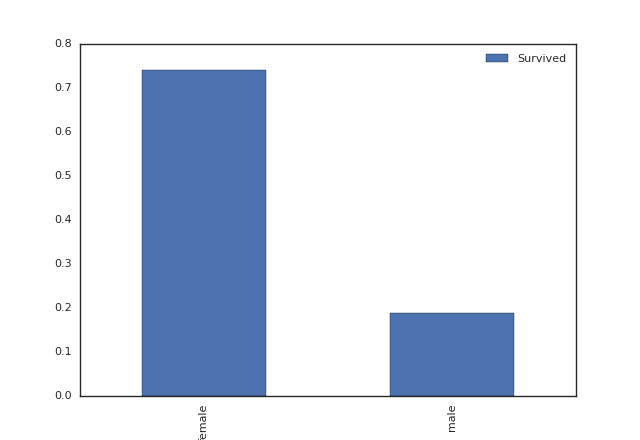

In [67]:
import matplotlib.pyplot as plt

%matplotlib notebook
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()


<IPython.core.display.Javascript object>


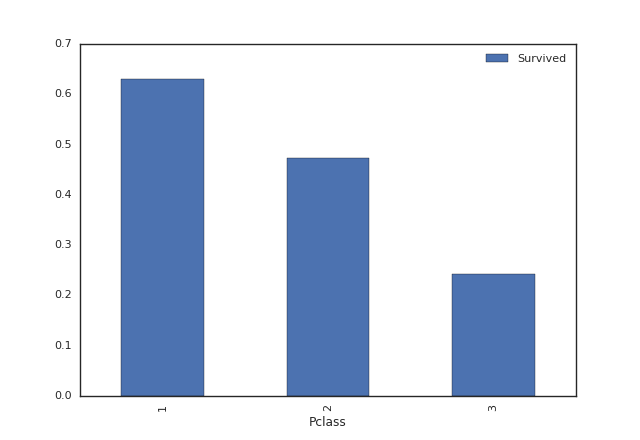

In [68]:
import matplotlib.pyplot as plt
%matplotlib notebook
pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

Let's then explore Age column, first by looking at its description. 

In [69]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The Age column contains numbers ranging from 0.42 to 80.0.

The other thing to note here is that there are 714 values in this column, fewer than the 891 rows we discovered that the train data set had earlier in this mission which indicates we have some missing values.

One way to look at distribution of values in a continuous numerical set is to use histograms. It would make sense to create two histograms to compare visually the those that survived vs those who died across different age ranges:

<IPython.core.display.Javascript object>


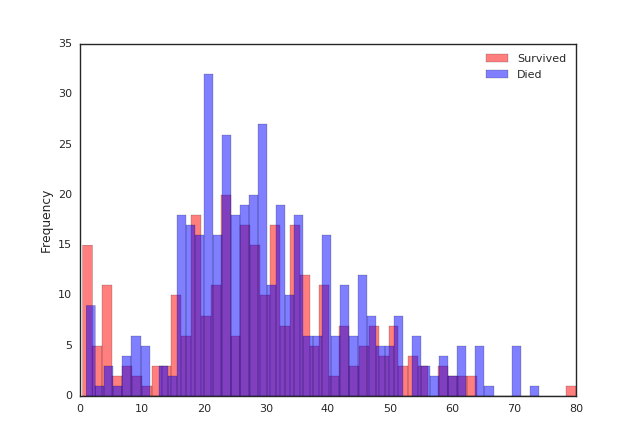

In [70]:
import matplotlib.pyplot as plt
%matplotlib notebook

survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but it is apparent that in some age ranges more passengers survived - where the red bars are higher than the blue bars.

In order for this to be useful to this machine learning model, it would make sense to separate this continuous feature into a categorical feature by dividing it into ranges.

<IPython.core.display.Javascript object>


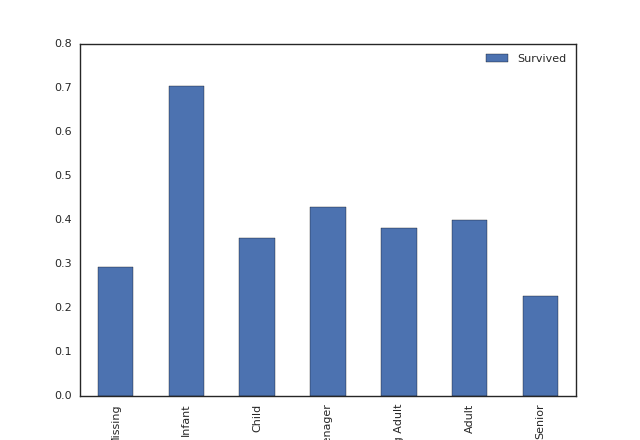

In [71]:
import matplotlib.pyplot as plt
%matplotlib notebook

def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

As shown in the chart, infants were the category with the highest survivor proportion, and the others were similar to each other.

# Preparing the Data

So far, three features that may be useful for prediting the survival rate have been examined. 

Before start building the model, it is necessary to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so the values must be converted into numbers.

Additionally, it is important to be careful to not imply any numeric relationship where there isn't one. The values in the Pclass column are 1, 2, and 3. 

In [72]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

While the class of each passenger certainly has some sort of ordered relationship, the relationship between each class is not the same as the relationship between the numbers 1, 2, and 3. For instance, class 2 isn't "worth" double what class 1 is, and class 3 isn't "worth" triple what class 1 is.

In order to remove this relationship, dummy columns should be created for each unique value in Pclass.

In [73]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

In [74]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


# First machine learning model: Logistic Regression

In [75]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In order to stop the model from overfitting the data, it is important to split the data into train and holdout data.

In [76]:
holdout = test # from now on we will refer to this

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

Now that the data is split into two parts, it is safe to fit the model. 

Once the model is trained, then it will be tested, and the accuracy would be measured as a score. 

It seems reasonable to calculate the accuracy score by the percentage of passenger survival rate correctly predicted. 

This can be done by using klearn.model_selection.train_test_split

In [77]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


The first model has an accuracy score of 81%. It is a good start, but there is a good chance that the model might be overfitting. 

In order to prevent this from happening, it is important to cross validate the result.

Will use 10 fold CV. 

In [78]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
0.8024670865963002


In [79]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

print(holdout_predictions)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


# Feature Selection

So far, the first logistic model created here used the features that were selected at my discretion (human decision making). 

Since it is tested that the basic logistic regression model with manual decision making, it would make sesne to move on and perform automated feature selection, which would rely on a function to select the fields that would contribute the most to correctly predicting whether a passenger survived the shipwreck or not. 

Let's begin by processing age and creating dummies, so that we can all the available columns that we can choose from. 

In [80]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = process_age(train)
holdout = process_age(holdout)

for column in ["Age_categories","Pclass","Sex"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


There are several columns in the first few lines that haven't been used in this model yet. 

PassengerId can be skipped, since this is just a column Kaggle have added to identify each passenger and calculate scores. 

Survived can also be skipped, as this is what we're predicting, as well as the three columns that were already used above.

Here is a list of the remaining columns that have not been used in the model. 

* SibSp - The number of siblings or spouses the passenger had aboard the Titanic
* Parch - The number of parents or children the passenger had aboard the Titanic
* Ticket - The passenger's ticket number
* Fare - The fair the passenger paid
* Cabin - The passengers cabin number
* Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

# Preprocessing the Data

There are fields other than sex, age and pclass that we may find relevant to this survival rate. 

There are values missing for several columns that we may find helpful. So we will clean and proess the missing values first. 

Let's create a functioni that fills missing values of "Fare" column with the average value and fills missing values of "Embarked" column with "S". We will show this in the next session. 

At first glance, both the Name and Ticket columns look to be unique to each passenger, but will be specifically analyzed later. 

Let's first examine the remaining columns that have not been used yet. 

In [81]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare        Cabin Embarked
count   891.000000  891.000000  891.000000          204      889
unique         NaN         NaN         NaN          147        3
top            NaN         NaN         NaN  C23 C25 C27        S
freq           NaN         NaN         NaN            4      644
mean      0.523008    0.381594   32.204208          NaN      NaN
std       1.102743    0.806057   49.693429          NaN      NaN
min       0.000000    0.000000    0.000000          NaN      NaN
50%       0.000000    0.000000   14.454200          NaN      NaN
max       8.000000    6.000000  512.329200          NaN      NaN


In [82]:
# %load functions.py
def process_missing(df):
    #Handle various missing values from the data set

    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

Of these, SibSp, Parch and Fare look to be standard numeric columns with no missing values. Cabin has values for only 204 of the 891 rows, and even then most of the values are unique, so for now this column will be skipped. Embarked looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. This can easily be filled with the most common value, "S" which occurs 644 times.

There is a big difference between the range of each numeric columns. SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, it is important to rescale the data.

In [83]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

columns = ["SibSp","Parch","Fare"]

train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])
    
train.head()

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64.



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled,Fare_scaled
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,1,0,0,1,0.125,0.0,0.014151
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,1,0,0,0.125,0.0,0.139136
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,1,0,0,0,1,0.000,0.0,0.015469
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,1,0,0,0,1,0.125,0.0,0.103644
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,1,0,0,1,0.000,0.0,0.015713


Fixed Embarked by filling in the missing values and creating dummies. 

Rescaled the SibSp, Parch, and Fare columns, assigning the results back to new columns SibSp_scaled, Parch_scaled. and Fare_scaled respectively.

Since the data is ready, now it would make sense to move on and select the most important features for making the prediction. 

This will be done by the logistic regressioin coefficients. 

<IPython.core.display.Javascript object>


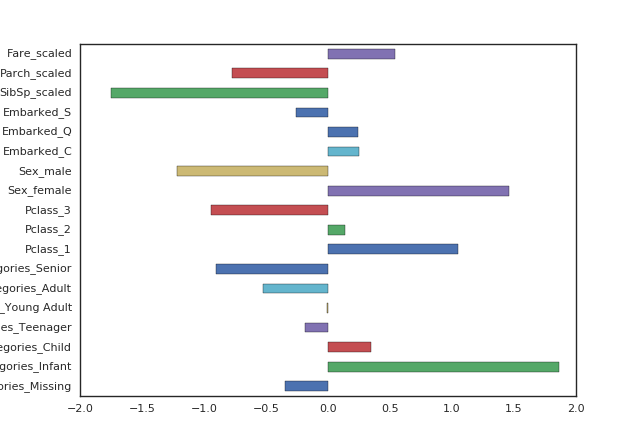

In [84]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

%matplotlib notebook
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=train[columns].columns)
feature_importance.plot.barh()
plt.show()

<IPython.core.display.Javascript object>


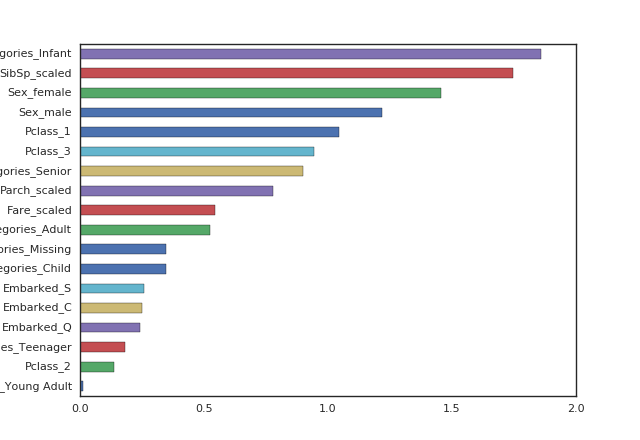

In [85]:
import matplotlib.pyplot as plt
%matplotlib notebook

ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()

Let's train a new model with the top 8 scores and check our accuracy using cross validation with a parameter of 10.

In [86]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148019521053229


The cross validation score of 81.48% is marginally higher than the cross validation score for the model created in the previous mission, which had a score of 80.2%.

Hopefully, this improvement will translate to previously unseen data. Let's train a model using the columns from the previous step, make some predictions on the holdout data and submit it to Kaggle for scoring.

In [87]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_1.csv",index=False)

# Feature engineering

The model is so far improved by selecting the most important features by using a function that looks at the coefficients of each field. 

Another way to improve the model is to engineer fatures out of the current information. 

One common way to engineer a feature is using a technique called binning. Binning is when you take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable. This can be useful when there are patterns in the data that are non-linear and you're using a linear model (like logistic regression). How "Age" was processed in this model is an example of binning. 



In [88]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

Another way to engineer features is by extracting data from text columns. Earlier, it was decided that the Name and Cabin columns weren't useful by themselves, but what if there is some data can still be extracted?

In [89]:
train[['Name', 'Cabin']].head()

,Name,Cabin
0,"Braund, Mr. Owen Harris",NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85
2,"Heikkinen, Miss. Laina",NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123
4,"Allen, Mr. William Henry",NaN


While in isolation the cabin number of each passenger will be reasonably unique to each, it is apparent that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for the model.

In [90]:
print(train.head()["Cabin"].str[0])

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Cabin, dtype: object


Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types:

* Mr
* Mrs
* Master
* Miss
* Officer
* Royalty

Let's extract some information out of them and create dummy columns.

In [91]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)


train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,0,1


There are now 34 possible feature columns that can be used to train the model. However, one column from each category should be ddeleted in order to prevent collinearity and therefore overfitting. 

<IPython.core.display.Javascript object>


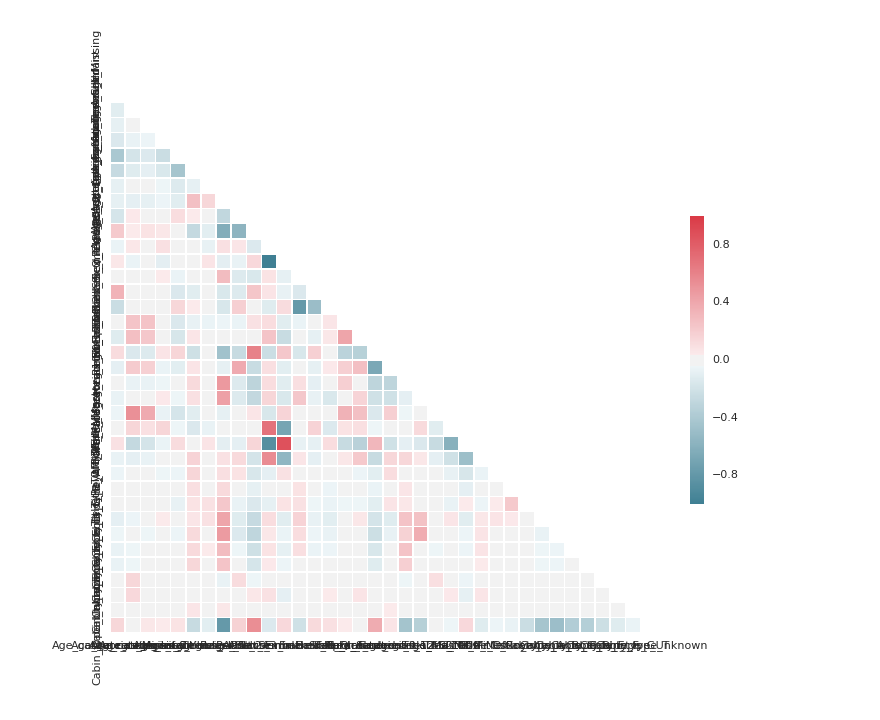

In [92]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']
plot_correlation_heatmap(train[columns])

In [43]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]
print(optimized_columns)

Index(['Pclass_3', 'SibSp_scaled', 'Title_Mr', 'Title_Mr', 'Title_Officer'], dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



Let's now train a model using cross validation using these columns and check the score.

In [93]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.84444444 0.84444444 0.78651685 0.86516854 0.84269663 0.78651685
 0.80898876 0.75280899 0.85393258 0.82954545]
0.8215063556917489


This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from the earlier model. Let's train these columns on the holdout set, save a submission file to Kaggle.

In [94]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_2.csv",index=False)

# Model Selection

It is time to move on from logistic regression, and also try out other models that can help this project better predict the survivors. 

Let's recap with how far this has progressed with logistic regression, then we will be using K-Nearest Neighbor. 

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_X = train[optimized_columns]
all_y = train["Survived"]

# all_X = train.drop(['Survived','PassengerId'],axis=1)
# all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.84444444 0.84444444 0.78651685 0.86516854 0.84269663 0.78651685
 0.80898876 0.75280899 0.85393258 0.82954545]
0.8215063556917489


In [103]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, all_X, all_y, cv=10)
accuracy_knn = scores.mean()
print(accuracy_knn)

0.7668990466462376


Since the accuracy is lower than what was achieved with logistic regression, it makes sense to try an additional method: hyperparameter optimization. 

# Hyperparameter Optimization

<IPython.core.display.Javascript object>


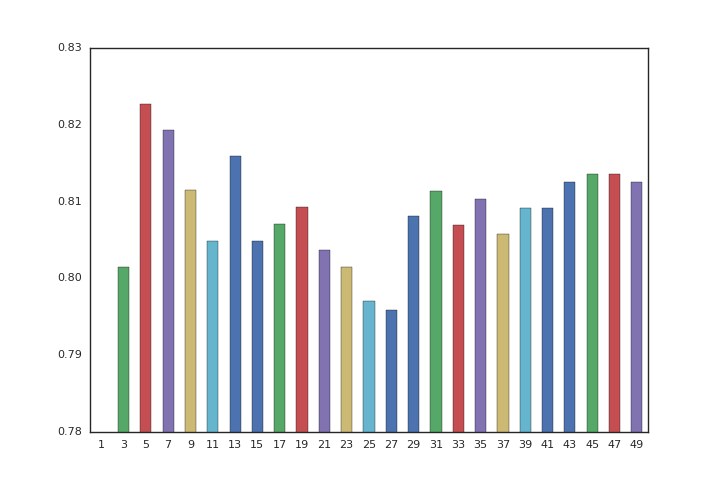

In [104]:
import matplotlib.pyplot as plt
%matplotlib notebook

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn

plot_dict(knn_scores)

In [105]:
print(knn_scores[5])

0.8226549199863806


5 gave the best score. Now let's another technique: grid search to find the best model with the best feature. 

In [113]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'weights': 'uniform', 'algorithm': 'brute', 'n_neighbors': 19, 'p': 1}
0.8215488215488216


# Random Forest

Another model I would like to try is random forest classifier becasue decision tree algorithms attempt to build the most efficient decision tree based on the training data.

In [114]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()
print(accuracy_rf)

0.8215313244807627


In [115]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}
clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)
grid.fit(all_X, all_y)
best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'n_estimators': 6, 'min_samples_split': 3, 'max_features': 'log2', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
0.8215488215488216


# Feature Selection for Random Forest

In [119]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,1,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,1,1


In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV #recursive feature elimination and cross val.

def select_features(df):
# Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1) #Make a decision tree
    selector = RFECV(clf,cv=10) #Select the most important (column) out of 10
    selector.fit(all_X,all_y) #Then, train the selection
    
    best_columns = list(all_X.columns[selector.support_]) #best columns
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)
# takes "train" df, edit and separate df
# run random forest (decision tree), select relevant columns
# fit df to the selected columms
# Reveal best columns -- through random forest & RFECV

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_C', 'Cabin_type_E', 'Cabin_type_Unknown', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#Choosing the best params, outputting scores for the best cols (features)
#Testing each parameter combination for each estimator (model)
def select_model(df, features): 
    all_X = df[features]
    all_y = df["Survived"]
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {"name": "LogisticRegression", 
        "estimator": LogisticRegression(),
        "hyperparameters": {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }},
        {"name": "KNeighborsClassifier", 
        "estimator": KNeighborsClassifier(),
        "hyperparameters": {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }},
        {"name": "RandomForestClassifier", 
        "estimator": RandomForestClassifier(),
        "hyperparameters": {
            "n_estimators": [4,6,9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }}
    ]
    for model in models:
        print(model['name'])
        print("-" * len(model['name']))
        grid = GridSearchCV(model['estimator'], 
                            param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train, cols)

LogisticRegression
------------------
Best Score: 0.8316498316498316
Best Parameters: {'solver': 'lbfgs'}

KNeighborsClassifier
--------------------
Best Score: 0.7878787878787878
Best Parameters: {'weights': 'uniform', 'algorithm': 'brute', 'n_neighbors': 7, 'p': 1}

RandomForestClassifier
----------------------
Best Score: 0.8417508417508418
Best Parameters: {'n_estimators': 9, 'min_samples_split': 5, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}



In [34]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    #for submission
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)